# Classification problem
### Considering binary gender classification
(0) Male

(1) Female

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate


%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

#from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [19]:
def import_data(fisher):
    if fisher == True:
        df = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/corr_matrices_fisher200.csv',index_col=['Institution','Subject'])
        phenotypic = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/phenotypic200.csv',index_col=['Institution','Subject'])
    else:
        df = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/corr_matrices200.csv',index_col=['Institution','Subject','Run'])
        phenotypic = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/phenotypic200.csv',index_col=['Institution','Subject'])
    return df,phenotypic

In [20]:
df, phenotypic = import_data(fisher=False)


In [22]:
df, phenotypic = import_data(fisher=True)
df = df.join(pd.DataFrame(phenotypic.Age), how='left')
df = df.join(pd.DataFrame(phenotypic['ADHD Measure']), how='left')
df = df.join(pd.DataFrame(phenotypic['Gender']), how='left')

#df = ((df.reset_index()).drop(columns=['Institution', 'Subject','Run'])).dropna(subset=[str(x) for x in range(0,61425)])
df = ((df.reset_index()).drop(columns=['Institution', 'Subject'])).dropna(subset=[str(x) for x in range(0,17954)])
df = df.dropna(axis=0, subset=['Gender'])
# Real test set
TEST =  df.iloc[-50:]

df = df.iloc[:-50]
y = (df.Gender).apply(lambda x: int(x))

# Remove from Fisher-space
X = np.tanh(df.iloc[:,:-3])

#X = (df.iloc[:,:-3])

In [23]:
ROI_labels = pd.read_csv('/Users/rodrigo/Post-Grad/CC400/ROI_labels.csv')

In [24]:
print(' 0 = {:.2f}% \n'.format(y.value_counts()[0]/len(y)), '1 = {:.2f}%'.format(y.value_counts()[1]/len(y)))

 0 = 0.37% 
 1 = 0.63%


In [25]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

In [26]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_test, y_test)
dummy_clf.predict(X_test)
print('Dummy_classifier acc {:.2f}'.format(dummy_clf.score(X_test,y_test)))

Dummy_classifier acc 0.66


### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Logistic Regression accuracy score in training set: {0:0.4f}'. format(accuracy_score(y_train, logreg.predict(X_train))))
print('Logistic Regression accuracy score in test set: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Logistic Regression accuracy score in training set: 1.0000
Logistic Regression accuracy score in test set: 0.7311


In [28]:
scores = cross_val_score(logreg, X_test, y_test, cv=5,scoring='accuracy')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.65 accuracy with a standard deviation of 0.07


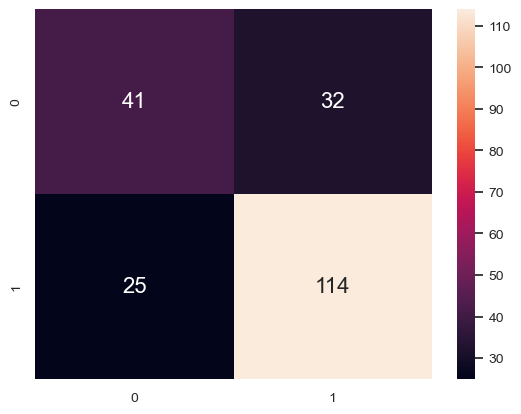

In [29]:
plt.figure(dpi=100)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()

In [30]:

f1_scores = cross_val_score(logreg, X, y, cv=5, scoring='f1_macro')
precision_scores = cross_val_score(logreg, X, y, cv=5, scoring='precision_macro')
recall_scores = cross_val_score(logreg, X, y, cv=5, scoring='recall_macro')

print("F1_scores {} accuracy with a standard deviation of {}".format(f1_scores.mean(), f1_scores.std()))
print("Precision_scores {} accuracy with a standard deviation of {}".format(precision_scores.mean(), precision_scores.std()))
print("Recall_scores {} accuracy with a standard deviation of {}".format(recall_scores.mean(), recall_scores.std()))

#print(f1_score(y_test, y_pred, average="macro"))
#print(precision_score(y_test, y_pred, average="macro"))
#print(recall_score(y_test, y_pred, average="macro"))  

F1_scores 0.6353094838036542 accuracy with a standard deviation of 0.02411235442705938
Precision_scores 0.6856870381158836 accuracy with a standard deviation of 0.060672917148941456
Recall_scores 0.6335724575050418 accuracy with a standard deviation of 0.02256954877816971


In [31]:
y_score = logreg.predict_proba(X_test)

y_score = y_score[:,1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

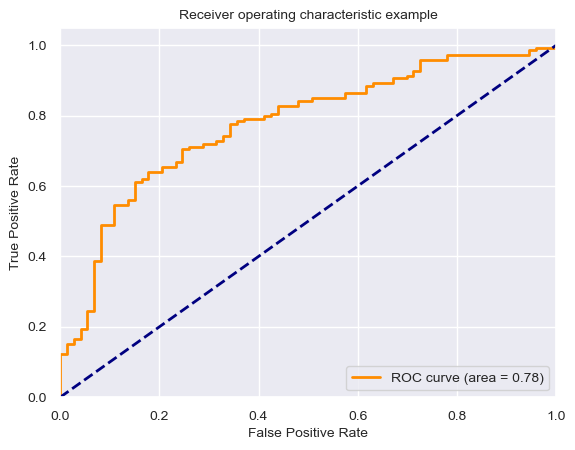

In [32]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

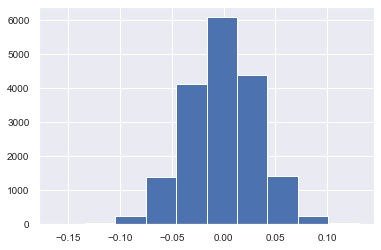

In [43]:
# get importance
importance = logreg.coef_[0]
importance = np.sort(importance)

plt.hist(importance)
plt.show()

## SVM

### XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV


# Setting possible values for the multiple hyperparameters of XGBoost
random_grid = {
    "max_depth": [1, 2, 3],
    "learning_rate": [0.001,0.05, 0.5],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0.001, 1, 10],
    "scale_pos_weight": [0,1, 3],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "n_estimators" : [int(x) for x in np.linspace(start = 50, stop = 200, num = 3)]

}

# Using  Boosted trees
bst = XGBClassifier(booster='gbtree',tree_method='exact',objective='binary:logistic',n_jobs=-1)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = bst, param_distributions = random_grid, n_iter = 100,
                               cv = 3, verbose=1, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train.values.ravel())


Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
accuracy = rf_random.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

In [ ]:
print(rf_random.best_params_)

In [ ]:
scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
          'f1' : 'f1_macro'}

In [ ]:
# Best xgboosting model
final_cl = XGBClassifier(
    **rf_random.best_params_,
    objective="binary:logistic",
    booster='gbtree',
    tree_method='exact',
    n_jobs=-1
)

scores = cross_validate(bst, X_train, y_train.values.ravel(), scoring=scoring,
                         cv=5, n_jobs=-1,verbose=1)

bst.fit(X_train, y_train.values.ravel())